In [1]:
%matplotlib inline
import math
import random
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{time.time() - t:.5f} sec')

t = time.time()
d = a + b
print(d.shape)
print(f'{time.time() - t:.5f} sec')

0.14747 sec
torch.Size([10000])
0.00000 sec


In [3]:
del a,b,c,d
import gc
gc.collect()

0

In [4]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

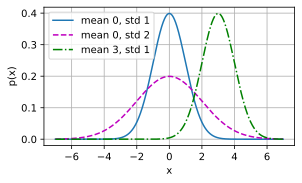

In [5]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [6]:
#Object-Oriented Design for Implementation
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        print("Something is happening before the function is called.")
        setattr(Class, obj.__name__, obj)
        print("Something is happening AFTER the function is called.")
    return wrapper

In [8]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [9]:
@add_to_class(A)  #@means 对函数进行修饰
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Something is happening before the function is called.
Something is happening AFTER the function is called.
Class attribute "b" is 1


In [10]:
class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [11]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        #self.save_hyperparameters()
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [12]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

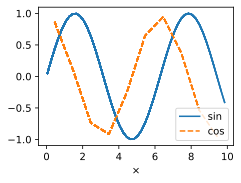

In [13]:
board = d2l.ProgressBoard('×')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

In [14]:
class Module(nn.Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [15]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [16]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

In [17]:
class SyntheticRegressionData(d2l.DataModule):
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        print(n, len(w))
        self.X = torch.randn(n, len(w))
        noise_ = torch.randn(n, 1) * noise
        print(noise_.shape)
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise_
        print(self.X.shape)
        print(self.y.shape)
        print(self.X[:10, :])

In [18]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

2000 2
torch.Size([2000, 1])
torch.Size([2000, 2])
torch.Size([2000, 1])
tensor([[-0.4960, -0.9427],
        [-0.9162,  1.0324],
        [-1.1230,  2.6393],
        [ 0.3663, -0.9432],
        [-0.5372, -1.4270],
        [-0.3873,  1.1305],
        [-1.1139, -1.6718],
        [-0.7876,  0.3450],
        [ 0.8850,  1.7999],
        [ 0.4521, -0.1040]])


In [19]:
data.X.shape

torch.Size([2000, 2])

In [20]:
data.y.shape

torch.Size([2000, 1])

In [21]:
data.X

tensor([[-4.9603e-01, -9.4269e-01],
        [-9.1625e-01,  1.0324e+00],
        [-1.1230e+00,  2.6393e+00],
        ...,
        [ 1.1396e-01, -8.6799e-01],
        [-2.1916e-03,  6.5849e-01],
        [ 7.6966e-01,  6.0667e-02]])

In [22]:
data.y

tensor([[ 6.4075],
        [-1.1546],
        [-7.0159],
        ...,
        [ 7.3780],
        [ 1.9542],
        [ 5.5265]])

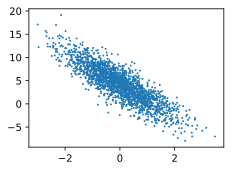

In [23]:
d2l.set_figsize()
d2l.plt.scatter(data.X[:, (1)].detach().numpy(), data.y.detach().numpy(), 1);

In [24]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [25]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [26]:
print(X)
print(y)
		
len(list(data.train_dataloader()))

tensor([[-0.9447, -0.0618],
        [-0.4128, -2.2852],
        [-0.2079, -1.2859],
        [-2.3201,  0.0714],
        [-1.0597,  0.3238],
        [ 0.5966, -0.8281],
        [ 0.8262,  0.0846],
        [-0.5428, -0.2678],
        [ 0.6724,  0.0960],
        [ 0.8994,  1.0275],
        [-0.2556,  0.5657],
        [-0.2580,  1.3488],
        [ 0.5919, -0.8902],
        [-0.3741, -0.4092],
        [ 0.7253,  1.2133],
        [-0.9659, -1.0911],
        [ 0.5370, -1.8354],
        [-0.2791, -1.5239],
        [ 0.7116, -1.6175],
        [-1.1212, -0.6421],
        [-2.1129, -1.7462],
        [ 0.0808, -0.2684],
        [-0.6161, -0.1624],
        [-0.9158, -0.2917],
        [-0.2567,  0.2559],
        [ 0.1793, -1.5801],
        [ 1.6348, -1.2252],
        [-1.2759, -2.3201],
        [ 0.7524, -1.1638],
        [-0.5436,  1.4244],
        [ 0.2324, -0.5994],
        [ 1.4466, -0.0709]])
tensor([[ 2.5123],
        [11.1419],
        [ 8.1449],
        [-0.6838],
        [ 0.9781],
        

32

In [27]:
len(list(data.train_dataloader()))

32

In [28]:
#Concise Implementation of the Data Loader
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    print(i)
    return self.get_tensorloader((self.X, self.y), train, i)

In [29]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)		
print(X)
print(y)

slice(0, 1000, None)
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
tensor([[-0.5746,  1.5460],
        [-1.2759, -2.3201],
        [ 1.1178, -0.3141],
        [-0.0581, -0.5971],
        [ 0.6206,  1.2757],
        [ 0.3728, -0.3241],
        [ 1.6209, -1.2629],
        [ 0.9725, -0.7164],
        [-0.7201, -1.5702],
        [-0.0776,  0.6341],
        [-0.3158,  0.0645],
        [ 1.8558, -0.2774],
        [ 0.4008,  0.1638],
        [ 0.0655, -0.0405],
        [ 0.6199,  0.0326],
        [ 3.8135, -2.1465],
        [-0.5436,  1.4244],
        [ 0.7870, -2.4544],
        [ 1.2999, -0.2782],
        [-0.5823, -1.9433],
        [-0.2413, -0.2393],
        [-0.2791, -1.5239],
        [ 0.3923, -2.1755],
        [-1.3205,  0.3856],
        [-0.9149,  1.2905],
        [ 0.3838, -0.1718],
        [ 0.5079, -1.9952],
        [ 0.4513, -1.5002],
        [-0.0378, -0.4277],
        [-0.1513, -0.6047],
        [-0.6471, -0.1118],
        [ 2.0458,  0.4650]])
tensor([[-2.2128],
    

In [30]:
len(data.train_dataloader())

slice(0, 1000, None)


32

In [31]:
#Linear Regression Implementation from Scratch
%matplotlib inline
import torch
from d2l import torch as d2l

In [32]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [33]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

In [34]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

In [35]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [36]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [37]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

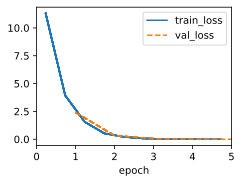

In [38]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

In [39]:
data.X.shape

torch.Size([2000, 2])

In [40]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0226, -0.0231])
error in estimating b: tensor([0.0278])


In [41]:
print(data.w), print(data.b)

tensor([ 2.0000, -3.4000])
4.2


(None, None)

In [42]:
print(model.w), print(model.b)

tensor([[ 1.9774],
        [-3.3769]], requires_grad=True)
tensor([4.1722], requires_grad=True)


(None, None)

error in estimating w: tensor([ 0.0065, -0.0169])
error in estimating b: tensor([0.0171])


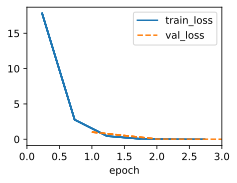

In [43]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
		
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)
	
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

In [44]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [45]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [46]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [47]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))
    #print(model.w)

L2 norm of w: 0.009822473861277103


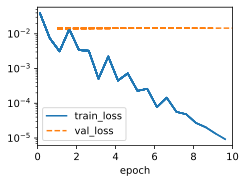

In [48]:
train_scratch(0)

L2 norm of w: 0.0015439277049154043


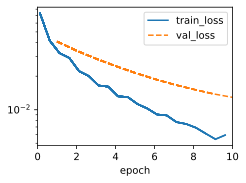

In [49]:
train_scratch(3)

In [50]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.0035541884135454893


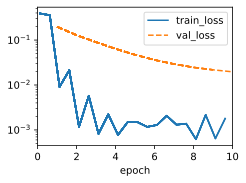

In [51]:
model = WeightDecay(wd=5, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

In [52]:
def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [53]:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

num_gpus()

0